<a href="https://colab.research.google.com/github/omer358/ml-acamey/blob/master/potato_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Conect the drive to load the dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


unzip the dataset 

In [3]:
!unzip /content/drive/MyDrive/ml/Potato/PlantVillage.zip

Archive:  /content/drive/MyDrive/ml/Potato/PlantVillage.zip
   creating: PlantVillage/
   creating: PlantVillage/Potato___Early_blight/
  inflating: PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG  
  inflating: PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG  
  inflating: PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG  
  inflating: PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG  
  inflating: PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG  
  inflating: PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG  
  inflating: PlantVillage/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG  
  inflating: PlantVillage/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 854

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

Load the data using `tf.keras.preprocessing.image_dataset_from_directory`

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


The name of the classes of the potatos

In [6]:
class_names = dataset.class_names

visualizing the dataset 

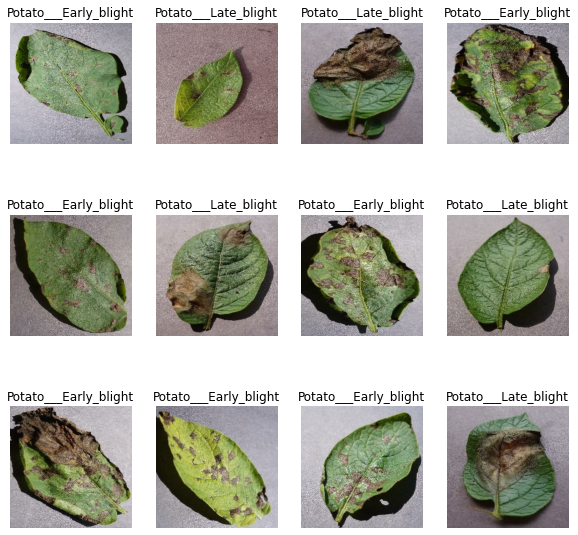

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle : 
    ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])